1. Extraire les données de la DataBase

In [2]:
import psycopg2

# Connecting to the Database
print("Trying to connect to db")
conn = psycopg2.connect(
    database="piscineds",
    user="ggobert",
    password="mysecretpassword",
    host=0
)
print("Connection success!")

cur = conn.cursor()
cur.execute(""" SELECT * FROM  customers """)
results = cur.fetchall()

cur.close()
conn.close()

# 1m 56.0s

Trying to connect to db
Connection success!


2. Formatter les données

In [3]:
import pandas as pd

# Nommer les colonnes du tableau
colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(results, columns=colnames)

# Enlever les '$' au prix
df['price'] = df['price'].replace('[$,]', '', regex=True).astype(float)

# Formatter les date en datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Seulement les évenements 'purchase'
df_purchase = df[df['event_type'] == 'purchase']

# 1m 43.9s

3. Nombre d'achat par Utilisateur

In [4]:
# Compter le nombre d'achats pour chaque utilisateur
purchase_counts = df_purchase.groupby('user_id').size().reset_index(name='purchase_count')


4. Ancienneté de l'utilisateur

In [5]:
# Calculer la date du premier achat pour chaque utilisateur
first_purchase = df_purchase.groupby('user_id')['event_time'].min().reset_index()
first_purchase.columns = ['user_id', 'first_purchase_date']

# Trouver la date du dernier achat dans le DataFrame
last_purchase_date = df_purchase['event_time'].max()

# Calculer le nombre de jours depuis le premier achat jusqu'à la dernière date dans le DataFrame
first_purchase['days_since_first_to_last'] = (last_purchase_date - first_purchase['first_purchase_date']).dt.days

# Fusionner le tout pour obtenir un DataFrame final pour le clustering
final_data = purchase_counts.merge(first_purchase[['user_id', 'days_since_first_to_last']], on='user_id')

5. Méthode du Coude

In [6]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_data)
    inertia.append(kmeans.inertia_)

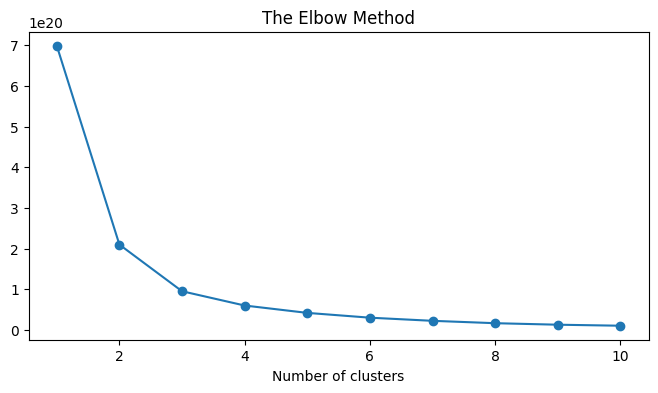

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.show()

Visualisation pré Clustering

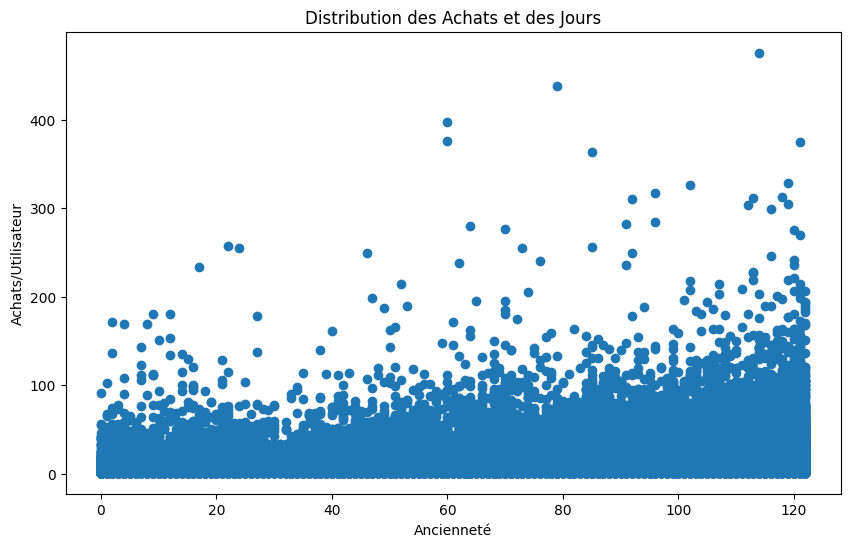

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(final_data['days_since_first_to_last'], final_data['purchase_count'])
plt.title('Distribution des Achats et des Jours')
plt.ylabel('Achats/Utilisateur')
plt.xlabel('Ancienneté')
plt.show()


6. Normalisation 

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
final_data_scaled = scaler.fit_transform(final_data[['purchase_count', 'days_since_first_to_last']])

7. Clustering

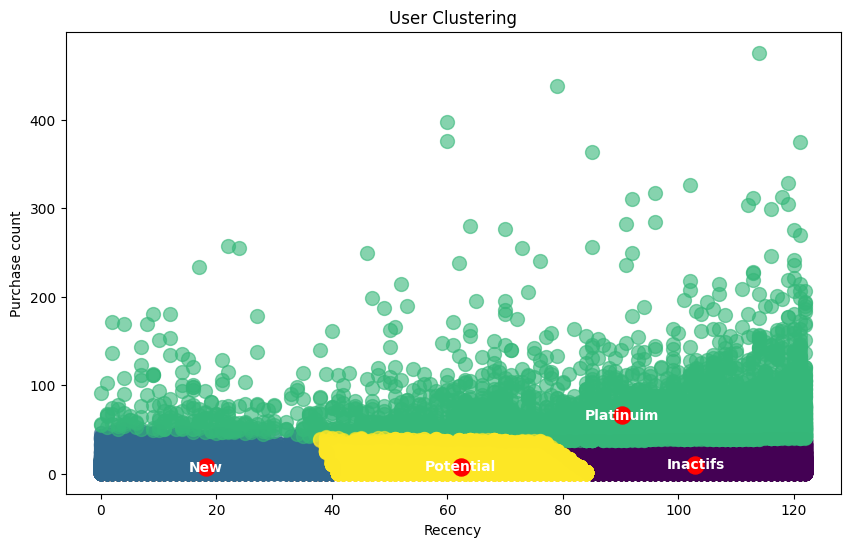

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Utilisation du model Kmean
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(final_data_scaled)

# Ajout des labels de clusters aux données originales
final_data['cluster'] = kmeans.labels_

# Mapping des étiquettes numériques aux noms
cluster_names = {
    0: 'Inactifs',
    1: 'New',
    2: 'Platinuim',
    3: 'Potential'
}
final_data['cluster_name'] = final_data['cluster'].map(cluster_names)

# Création de la palette de couleurs basée sur les étiquettes de cluster originales
color_map = plt.cm.viridis(np.linspace(0, 1, len(cluster_names)))
colors = {name: color for name, color in zip(cluster_names.values(), color_map)}

# Visualisation des clusters avec annotations
plt.figure(figsize=(10, 6))
for name, color in colors.items():
    subset = final_data[final_data['cluster_name'] == name]
    scatter = plt.scatter(subset['days_since_first_to_last'], subset['purchase_count'], s=100, color=color, label=name, alpha=0.6)

# Extraction et affichage des centroids
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)
for i, (x, y) in enumerate(centroids_original):
    plt.scatter(y, x, c='red', s=150, marker='o')  # Centroids comme grands points rouges
    plt.text(y, x, cluster_names[i], color='white', ha='center', va='center', fontweight='bold')

plt.xlabel('Recency')
plt.ylabel('Purchase count')
plt.title('User Clustering')
plt.show()


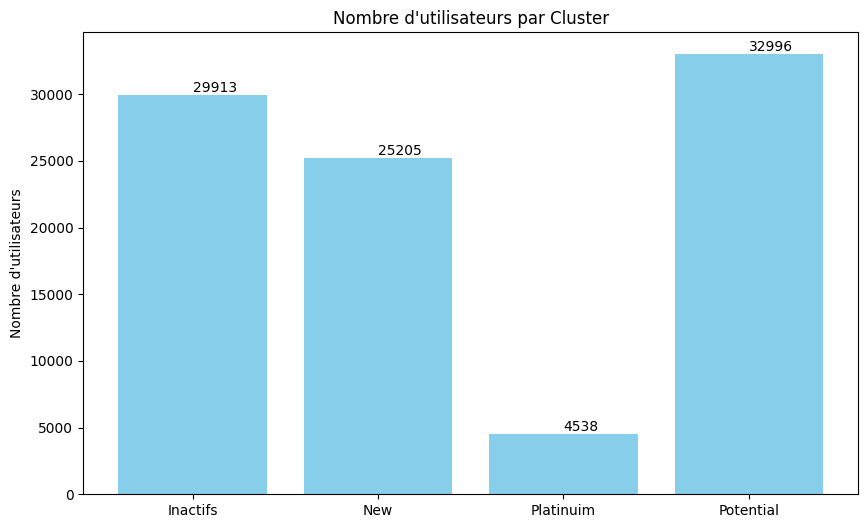

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Compter le nombre d'instances dans chaque cluster
cluster_counts = final_data['cluster_name'].value_counts().reset_index()
cluster_counts.columns = ['Cluster Name', 'Count']

# Trier les clusters si nécessaire, par exemple dans un ordre spécifique ou alphabétique
cluster_counts = cluster_counts.sort_values('Cluster Name')

# Créer le graphique à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts['Cluster Name'], cluster_counts['Count'], color='skyblue')

# Ajouter des étiquettes pour chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom')  # va: vertical alignment

# Ajouter des titres et des labels aux axes
plt.title('Nombre d\'utilisateurs par Cluster')
plt.ylabel('Nombre d\'utilisateurs')
plt.show()
